<a href="https://colab.research.google.com/github/djiraffs/Deep-Learning/blob/main/Tugas_DL_1_Infrared_Raffalino.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Membuat Data cleaning dan converting **

> Add blockquote



In [6]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load the dataset
file_path = '/content/Infrared.csv'
data = pd.read_csv(file_path)

# Display the first few rows to understand its structure
data.head()


,Gender,Age,Ethnicity,T_atm,Humidity,Distance,T_offset1,Max1R13_1,Max1L13_1,aveAllR13_1,...,T_FHRC1,T_FHLC1,T_FHBC1,T_FHTC1,T_FH_Max1,T_FHC_Max1,T_Max1,T_OR1,T_OR_Max1,aveOralM
0,Male,41-50,White,24.0,28.0,0.8,0.7025,35.0300,35.3775,34.4000,...,33.4775,33.3725,33.4925,33.0025,34.5300,34.0075,35.6925,35.6350,35.6525,36.59
1,Female,31-40,Black or African-American,24.0,26.0,0.8,0.7800,34.5500,34.5200,33.9300,...,34.0550,33.6775,33.9700,34.0025,34.6825,34.6600,35.1750,35.0925,35.1075,37.19
2,Female,21-30,White,24.0,26.0,0.8,0.8625,35.6525,35.5175,34.2775,...,34.8275,34.6475,34.8200,34.6700,35.3450,35.2225,35.9125,35.8600,35.8850,37.34
3,Female,21-30,Black or African-American,24.0,27.0,0.8,0.9300,35.2225,35.6125,34.3850,...,34.4225,34.6550,34.3025,34.9175,35.6025,35.3150,35.7200,34.9650,34.9825,37.09
4,Male,18-20,White,24.0,27.0,0.8,0.8950,35.5450,35.6650,34.9100,...,35.1600,34.3975,34.6700,33.8275,35.4175,35.3725,35.8950,35.5875,35.6175,37.04


In [14]:
data = data.dropna()

In [15]:
categorical_columns = ["Gender", "Age", "Ethnicity"]
numerical_columns = list(set(data.columns) - set(categorical_columns) - {"aveOralM"})

In [16]:
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')
data[categorical_columns] = cat_imputer.fit_transform(data[categorical_columns])
data[numerical_columns] = num_imputer.fit_transform(data[numerical_columns])

In [17]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
categorical_data = encoder.fit_transform(data[categorical_columns])
categorical_df = pd.DataFrame(categorical_data, columns=encoder.get_feature_names_out(categorical_columns))


In [18]:
scaler_X = StandardScaler()
numerical_data = scaler_X.fit_transform(data[numerical_columns])
numerical_df = pd.DataFrame(numerical_data, columns=numerical_columns)

In [19]:
scaler_y = StandardScaler()
target = scaler_y.fit_transform(data[["aveOralM"]]).flatten()

In [20]:
features = pd.concat([numerical_df, categorical_df], axis=1)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

Model deep learning Pytorch

In [22]:
X_train_torch = torch.tensor(X_train.values, dtype=torch.float32)
X_test_torch = torch.tensor(X_test.values, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [23]:
class DeepLearningModel(nn.Module):
    def __init__(self, input_dim):
        super(DeepLearningModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = DeepLearningModel(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Mentraining Model

In [24]:
epochs = 100
train_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    # Forward pass
    y_pred = model(X_train_torch)
    loss = criterion(y_pred, y_train_torch)
    train_losses.append(loss.item())
    # Backward pass
    loss.backward()
    optimizer.step()

    if (epoch+1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [50/100], Loss: 0.2597
Epoch [100/100], Loss: 0.1939


In [25]:
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_torch)

In [26]:
y_pred_test_np = y_pred_test.numpy()
y_test_np = y_test_torch.numpy()

mse = mean_squared_error(y_test_np, y_pred_test_np)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_np, y_pred_test_np)

In [27]:
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R^2: {r2:.4f}")

RMSE: 0.4831
MSE: 0.2334
R^2: 0.6955


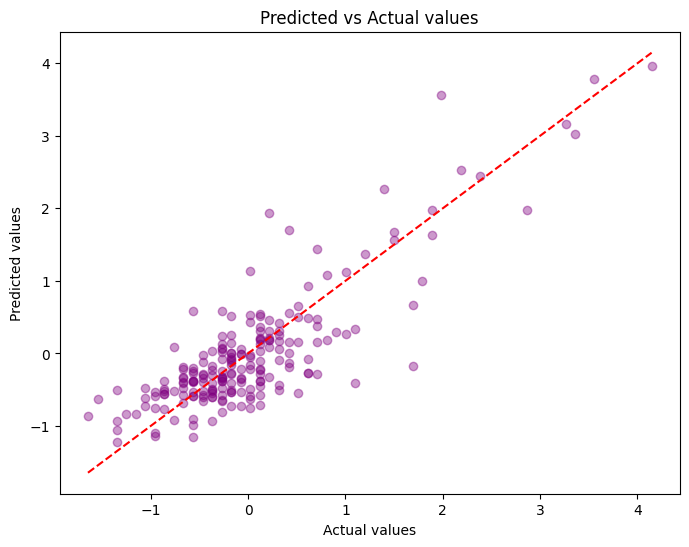

In [28]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_np, y_pred_test_np, color='purple', alpha=0.4)
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], color='red', linestyle='--')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Predicted vs Actual values')
plt.show()

**Deep Learning menggunakan Tensor FLow**

Membangun Model

In [29]:
model = keras.Sequential([
    layers.Dense(64, input_dim=X_train.shape[1], activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Output layer
])

# Kompilasi model dengan loss function dan optimizer
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Mentraining Model

In [31]:
epochs = 100
history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_test, y_test), verbose=0)

In [32]:
#Evaluasi Akhir
y_pred_test = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [33]:
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_test)

In [34]:
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R^2: {r2:.4f}")

RMSE: 0.6077
MSE: 0.3692
R^2: 0.5181


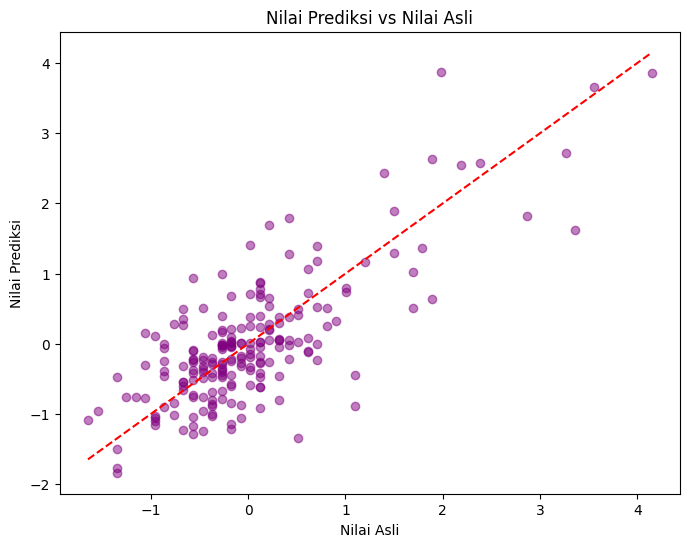

In [35]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_torch.numpy(), y_pred_test, color='purple', alpha=0.5)
plt.plot([y_test_torch.numpy().min(), y_test_torch.numpy().max()], [y_test_torch.numpy().min(), y_test_torch.numpy().max()], color='red', linestyle='--')
plt.xlabel('Nilai Asli')
plt.ylabel('Nilai Prediksi')
plt.title('Nilai Prediksi vs Nilai Asli')
plt.show()